In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
%matplotlib inline

In [44]:
!wget -O kc_house_data.csv https://raw.githubusercontent.com/mrezaprwr/kc-house-data_malin/master/kc_house_data.csv
dataset = pd.read_csv("kc_house_data.csv")

--2019-12-07 07:58:14--  https://raw.githubusercontent.com/mrezaprwr/kc-house-data_malin/master/kc_house_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368640 (360K) [text/plain]
Saving to: ‘kc_house_data.csv’

kc_house_data.csv   100%[===================>] 360.00K  --.-KB/s    in 0.04s   

2019-12-07 07:58:15 (8.55 MB/s) - ‘kc_house_data.csv’ saved [368640/368640]



Mengisi missing value pada data row terakhir

In [45]:
dataset.at[3164, 'sqft_living15'] = round(dataset['sqft_living15'].mean())
dataset.at[3164, 'sqft_lot15'] = round(dataset['sqft_lot15'].mean())
dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340.0,5650.0
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690.0,7639.0
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720.0,8062.0
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360.0,5000.0
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800.0,7503.0


In [46]:
target_label = dataset.price
trainData = dataset.drop(['id', 'date', 'price'], axis=1)
trainData.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340.0,5650.0
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690.0,7639.0
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720.0,8062.0
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360.0,5000.0
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800.0,7503.0


Visualisasi distribusi data

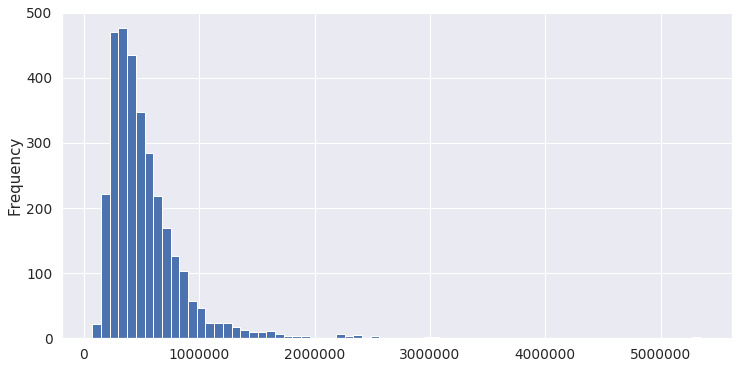

In [47]:
target_label.plot(kind='hist', bins=70, figsize = [12,6])

Melihat deskripsi data price

In [48]:
target_label.describe()

count    3.165000e+03
mean     5.354183e+05
std      3.808415e+05
min      7.500000e+04
25%      3.150000e+05
50%      4.450000e+05
75%      6.400000e+05
max      5.350000e+06
Name: price, dtype: float64

In [0]:
dfLabels = dataset.loc[:,['price']]

Normalize price (numerical)  into categorical data
Melakukan normalisasi data price yang bertipe numerikal menjadi kategori yang terbagi atas 3 kategori dengan range 


*   75000 - 315000
*   316000 - 640000
*   641000 - 535000



In [0]:
dfLabels['group'] = pd.cut(dfLabels['price'], bins=[75000, 315000, 640000, 5350000], labels=[1, 2, 3])

Mengisi missing value pada data hasil normalisasi

In [0]:
dfLabels['group']=dfLabels['group'].fillna(1)

Cek korelasi antar atribut menggunakan heatmap (Korelasi tidak dipastikan benar sepenuhnya)

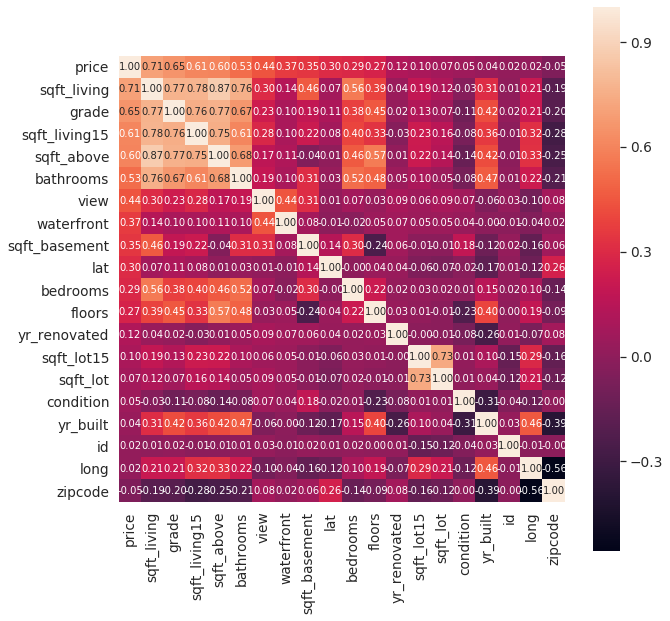

In [69]:
k = 21 #number of variables for heatmap
fig, ax = plt.subplots(figsize=(10,10))

corrmat = dataset.corr()
cols = corrmat.nlargest(k, 'price')['price'].index

cm = np.corrcoef(dataset[cols].values.T)

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Ubah target label (price) dari bentuk numerik menjadi kategori

In [0]:
target_label_c = dfLabels.group

Memilih fitur fitur yang memberikan akurasi terbesar dari percobaan

**Percobaan pertama** menggunakan fitur fitur yang berwana oren dari map korelasi yaitu:

['sqft_living', 'grade', 'sqft_living15', 'sqft_above', 'bathrooms', 'view', 'sqft_basement', 'bedrooms', 'yr_built', 'floors', 'yr_built'] 


Akurasi yang didapatkan dari subset diatas menggunakan ANN dengan beberapa parameter hasil percobaan yang telah dilakukan adalah +- 65%

**Percobaan kedua** menggunakan beberapa fitur di atas dengan tambahan beberapa fitur yang telah dilakukan pada beberapa kali percobaan

In [0]:
subset = ['sqft_living', 'grade', 'sqft_living15', 'bathrooms', 'floors', 'yr_built', 'long', 'view',
          'sqft_basement', 'zipcode']

In [0]:
sub_trainData = trainData.loc[:, subset]

Membagi data menjadi data train dan data test dengan rasio 60% data train dan 40% data train

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sub_trainData, target_label_c, test_size = 0.40, random_state=2)

## Melakukan klasifikasi menggunakan ANN dengan beberapa parameter yang dipilih

Normalisasi pada data dengan malakukan scaling terhadap data train dan test karena multi layer perceptron lebih sensitif terhadap feature scaling

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

**hidden layer (10,10,10)**

In [0]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(x_train, y_train)
y_pred_mlp = mlp.predict(x_test)

Cek Akurasi Performa Algoritma

In [143]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_mlp, normalize = True)

0.7124802527646129

Akurasi terbaik didapatkan menggunakan parameter dengan tiga layer dengan jumlah node pada layer masing masing sebanyak 10 sesuai dengan jumlah atribut data yang akan dilatih

In [144]:
from sklearn.metrics import classification_report,confusion_matrix
confusion_matrix(y_test,y_pred_mlp)

array([[203, 107,   2],
       [ 93, 479,  63],
       [  5,  94, 220]])

In [146]:
print(classification_report(y_test,y_pred_mlp))

              precision    recall  f1-score   support

           1       0.67      0.65      0.66       312
           2       0.70      0.75      0.73       635
           3       0.77      0.69      0.73       319

    accuracy                           0.71      1266
   macro avg       0.72      0.70      0.71      1266
weighted avg       0.71      0.71      0.71      1266



Didapatkan hasil akurasi sebesar 71% dengan data terklasifikasi yang salah sebesar  +- 30%